In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from src.ksd.models import create_mixture_gaussian

In [7]:
dim = 5
n = 500

# Oracle choice of variance

In [5]:
ratio_target = 0.3
ratio_sample = 0.7

In [6]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)
target_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

2022-01-14 09:19:11.433661: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-14 09:19:12.022808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


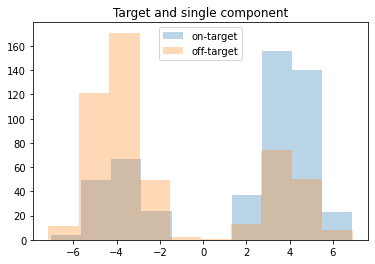

In [7]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [8]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

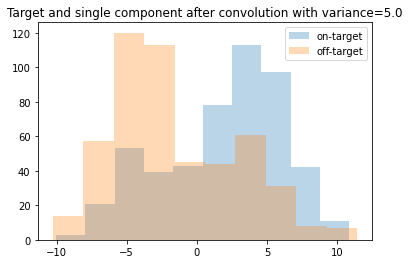

In [9]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title(f"Target and single component after convolution with variance={var}")

## Convolved KSD as a function of log std

In [10]:
from src.ksd.ksd import ConvolvedKSD
tf.random.set_seed(0)

In [11]:
ratio_target = 0.5
ratio_sample = 1.0

In [12]:
delta = 6.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))

kernel = IMQ(med_heuristic=True)

ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=None)

std_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-10., 10., 1.0).numpy()]

In [13]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

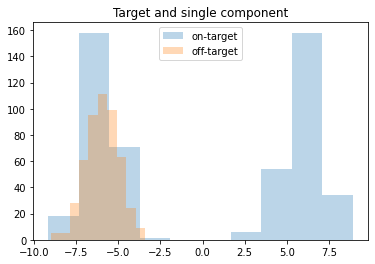

In [14]:
_ = plt.hist(on_sample.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(off_sample.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [15]:
ksd_df = pd.DataFrame(columns=["n", "ksd", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

#             # off-target sample
#             off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_off, np.exp(log_noise_std), seed, "off-target"]

#             # on-target sample
#             on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_on, np.exp(log_noise_std_on), seed, "target"]


  0%|          | 0/20 [00:00<?, ?it/s]

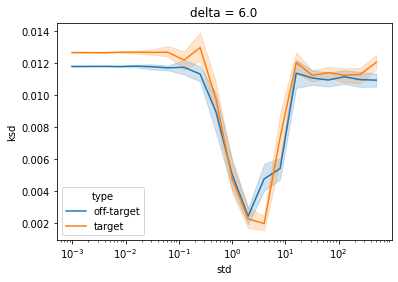

In [16]:
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"delta = {delta}")

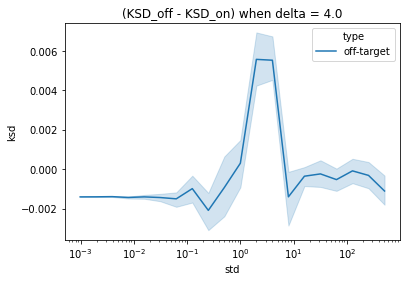

In [253]:
ksd_diff_df = ksd_df.loc[ksd_df.type == "off-target", ].copy()
ksd_diff_df["ksd"] = ksd_diff_df["ksd"].to_numpy() - ksd_df.loc[ksd_df.type == "target", "ksd"].to_numpy()

sns.lineplot(data=ksd_diff_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"(KSD_off - KSD_on) when delta = {delta}")

$\{v v^\intercal x: x \in \mathbb{R}^d \}$

$ \sigma Z, Z \sim N(0, I_d) $

$Z \sim N(0, 1)$, $\sigma v Z$

# MH approach

In [24]:
from src.ksd.langevin import RandomWalkMH
tf.random.set_seed(0)

In [25]:
ratio_target = 0.3
ratio_sample = 1.

In [26]:
delta = 4.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

In [27]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

In [28]:
steps = 20
std = 10.
x_init_off = tf.identity(off_sample)

mh_off = RandomWalkMH(log_prob=target_log_prob)
mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.88it/s]


In [29]:
# check if the hard-coded log_prob equals to the built-in fn
diff = target_log_prob(x_init_off) - target.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [30]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_sample.numpy()[:, 0], bins=20, label="target", alpha=0.4)
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

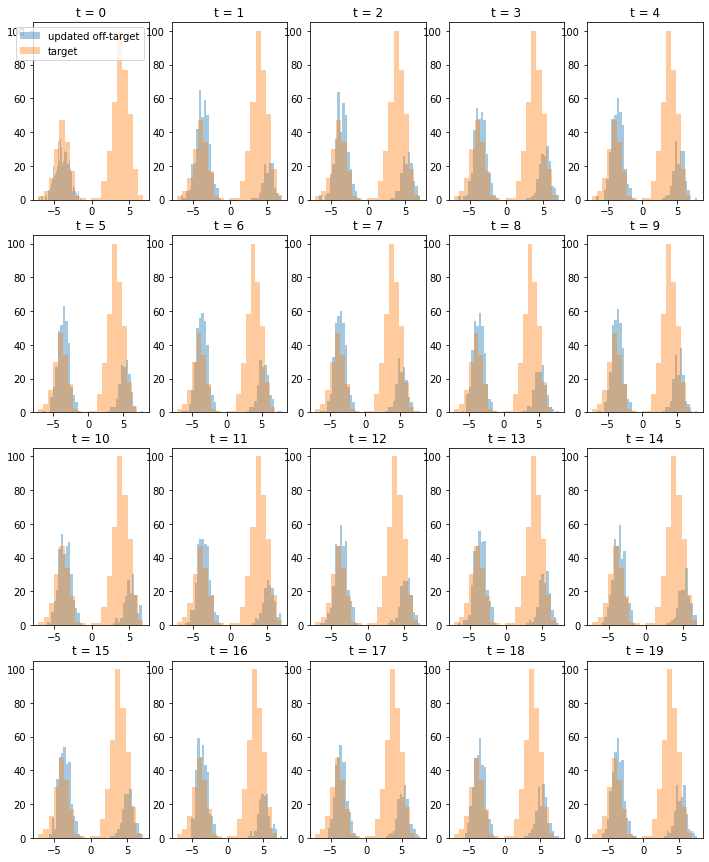

In [31]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [32]:
mh_on = RandomWalkMH(log_prob=target_log_prob)

x_init_on = tf.identity(on_sample)
mh_on.run(steps=steps, std=std, x_init=x_init_on)

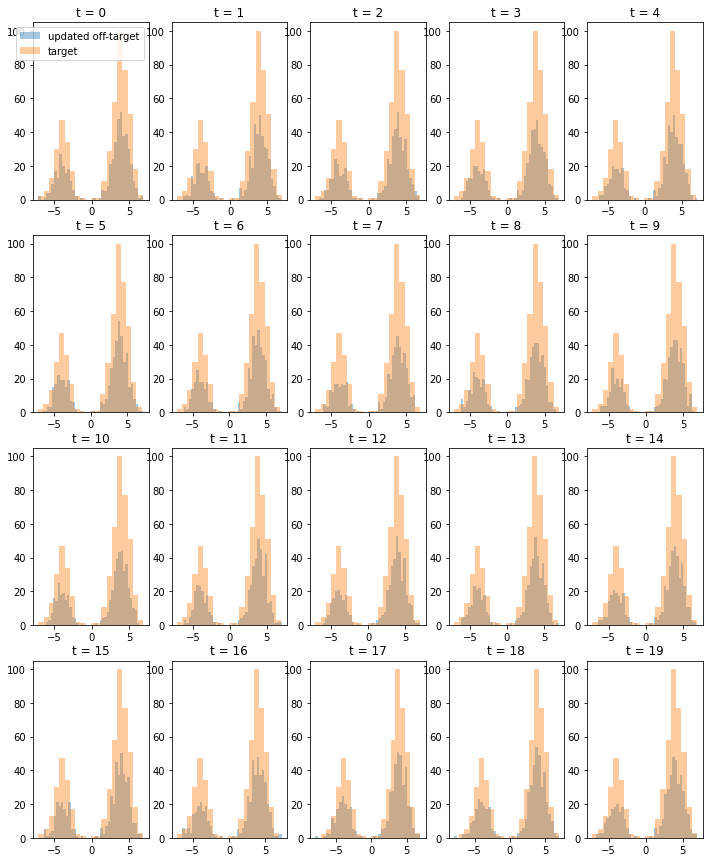

In [33]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of step

In [34]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [35]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=target_log_prob)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=target_log_prob)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [36]:
nsteps=20
std=10.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

<AxesSubplot:xlabel='t', ylabel='ksd'>

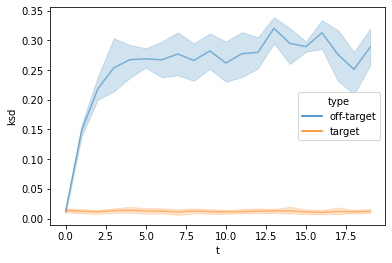

In [37]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Mixture of t and Banana distributions

In [185]:
import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
from src.ksd.ksd import KSD
from src.ksd.bootstrap import Bootstrap
from tqdm.notebook import tqdm, trange

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [186]:
tf.random.set_seed(0)

In [187]:
dim = 1

nmodes = 2
nbanana = 2
ratio_target = [1/nmodes] * nmodes

random_weights = tfp.distributions.Uniform(low=0., high=1.).sample(nmodes)
# indicator = tf.cast(tfp.distributions.Bernoulli(probs=0.5).sample(nmodes), dtype=bool)
# random_weights = tf.where(indicator, random_weights, 0.0)
# ratio_sample = random_weights / tf.reduce_sum(random_weights)

# loc = tf.constant([[4.1144876, 6.538103, 4.1443825, 4.311162, -9.23945],
#     [-4.1144876, -6., 0.08298874, -1.2335253, 7.6566525],
#     [-4.977256, 16.026318, 8.160973, 12.019077, -6.351266],
#     [ 5.583577, 10.599161, 13.44928, 1.0351582, 3.1638136 ]]) # diag
# loc = tf.constant([[4.1144876, 6.538103, 4.1443825, 4.311162, -9.23945],
#     [4.1144876, -6., 0.08298874, -1.2335253, 7.6566525],
#     [-4.977256, 16.026318, 8.160973, 12.019077, -6.351266],
#     [ 5.583577, 10.599161, 13.44928, 1.0351582, 3.1638136 ]]) # vert
# loc = tf.constant([[40.1144876, 6.538103, 4.1443825, 4.311162, -9.23945],
#     [-40.1144876, 6., 0.08298874, -1.2335253, 7.6566525],
#     [-4.977256, 16.026318, 8.160973, 12.019077, -6.351266],
#     [ 5.583577, 10.599161, 13.44928, 1.0351582, 3.1638136 ]]) # hori

loc = tf.constant([
    [40.1144876, 6.538103, 4.1443825, 4.311162, -9.23945],
    [-4.977256, 16.026318, 8.160973, 12.019077, -6.351266]]) # hori
# loc = tf.constant([
#     [0., 0., 0., 0., 0.],
#     [0., 0., 0., 0., 0.]])
loc = loc[:nmodes, :dim]

# ratio_sample = tf.constant([0.29207435, 0.305933, 0.3044154, 0.09757718]) #!

# loc = tfp.distributions.Uniform(low=-tf.ones((dim,))*10, high=tf.ones((dim,))*20).sample(nmodes) # uniform in [-20, 20]^d

banana_scale = 10.
b = 0.003
# target, log_prob_fn = models.create_mixture_t_banana(
#     dim=dim, ratio=ratio_target, loc=loc, b=b, return_logprob=True, nbanana=nbanana, scale=banana_scale)
# proposal_off, log_prob_off_fn = models.create_mixture_t_banana(
#     dim=dim, ratio=ratio_sample, loc=loc, b=b, return_logprob=True, nbanana=nbanana, scale=banana_scale)

In [188]:
target, log_prob_fn = models.create_mixture_gaussian_scaled(ratio=0.5, return_logprob=True)
# log_prob_fn = target.log_prob
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_scaled(ratio=0.5, return_logprob=True)
proposal_off, log_prob_off_fn = target, log_prob_fn #!

In [189]:
# # ratio_sample = [0.95802206, 0., 0., 0.04197793]
# ratio_sample = [0.95802206, 0.04197793]
# delta = 1. # 4.
        
# target, log_prob_fn = models.create_mixture_20_gaussian(loc, ratio=ratio_target, scale=delta, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_20_gaussian(loc, ratio=ratio_sample, scale=delta, return_logprob=True)
# proposal_off, log_prob_off_fn = target, log_prob_fn #!

In [190]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

In [191]:
# # sns.displot(data=samples_df, x="x0", y="x1", kind="kde", hue="type")
# sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")
# # plt.xlim(-50, 50)
# # plt.ylim(-50, 50)

In [192]:
# sns.displot(data=samples_df, x="x2", y="x3", kind="kde", hue="type")
# sns.scatterplot(data=samples_df, x="x2", y="x3", hue="type")
# plt.xlim(-30, 30)
# plt.ylim(-30, 30)

In [193]:
# find modes
ntrain = n // 2
threshold = 1.
sample_off_train, sample_off_test = samples_off[:ntrain, ], samples_off[ntrain:, ]

#TODO start optim from samples
start_pts = sample_off_train
# merge modes
# bfgs = run_bfgs(start_pts, log_prob_fn, verbose=True, tolerance=1e-18)
# end_pts = bfgs.position.numpy()
# len(end_pts)
mode_list, hess_list = find_modes(start_pts, log_prob_fn, threshold=threshold)

In [194]:
mode_list, hess_list

([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-10.], dtype=float32)>,
  <tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.], dtype=float32)>],
 [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>])

In [195]:
# dim1, dim2 = 0, 1
# end_pts = tf.concat([tf.reshape(x, (1, -1)) for x in mode_list], axis=0).numpy()
# plt.scatter(samples_on_df[f"x{dim1}"], samples_on_df[f"x{dim2}"], label="true", alpha=0.1)
# plt.scatter(start_pts[:, dim1], start_pts[:, dim2], label="start", alpha=0.3)
# plt.scatter(end_pts[:, dim1], end_pts[:, dim2], label="end", alpha=.3)
# plt.legend()

In [196]:
def find_best_dir_and_dist(mode_list, hess_list, sample_init, ntrain, T):

    std_ls = np.linspace(0.5, 1.5, 26).tolist()

    sample_init_train, sample_init_test = sample_init[:ntrain, ], sample_init[ntrain:, ]

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target, kernel=kernel)
    
    best_ksd = 0.
    best_ind = 0
    if len(mode_list) == 1:
        dir_vec_list = [mode_list[0]]
    else:
        dir_vec_list, ind_pair_list = pairwise_directions(mode_list, return_index=True)
        
    for j in trange(len(dir_vec_list)):
        # loop through directional vecs
        dir_vec = dir_vec_list[j] 
        ind1, ind2 = ind_pair_list[j]

        mode1, mode2 = mode_list[ind1], mode_list[ind2]
        hess1, hess2 = hess_list[ind1], hess_list[ind2]
        hess1_sqrt = tf.linalg.sqrtm(hess1)
        hess2_sqrt = tf.linalg.sqrtm(hess2)
        hess1_inv_sqrt = tf.linalg.inv(hess1_sqrt)
        hess2_inv_sqrt = tf.linalg.inv(hess2_sqrt)

        for i, std in enumerate(std_ls):
            # loop through jump scales

            # run dynamic for T steps
            mh = MCMCKernel(log_prob=log_prob_fn)
#             mh.run(steps=T, std=std, x_init=sample_init_train, dir_vec=dir_vec)

            mh.run(steps=T, std=std, x_init=sample_init_train, mode1=mode1, mode2=mode2,
                  hess1_sqrt=hess1_sqrt, hess2_sqrt=hess2_sqrt,
                  hess1_inv_sqrt=hess1_inv_sqrt, hess2_inv_sqrt=hess2_inv_sqrt)

            # compute ksd
            x_t = mh.x[-1, :, :].numpy()
#             ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            _, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
            ksd_val = ksd_val.numpy()

            # update if ksd is larger
            if ksd_val > best_ksd:
                best_std = std
                best_dir_vec = dir_vec
                best_ksd = ksd_val
                best_ind = j
                
#     return best_std, best_dir_vec, best_ind
    return best_std, best_dir_vec, best_ind, mode1, mode2, hess1_sqrt, hess2_sqrt, hess1_inv_sqrt, hess2_inv_sqrt

In [197]:
T = 50

In [198]:
# # best_std, best_dir_vec, best_ind = find_best_dir_and_dist(
# #     mode_list=mode_list, sample_init=samples_off, ntrain=ntrain, T=T)

# best_std, best_dir_vec, best_ind, mode1, mode2, hess1_sqrt, hess2_sqrt, hess1_inv_sqrt, hess2_inv_sqrt = find_best_dir_and_dist(
#     mode_list=mode_list, hess_list=hess_list, sample_init=samples_off, ntrain=ntrain, T=T)

In [246]:
#! delete
# mode1 = tf.constant([-4.977256, 16.026318])
# mode2 = tf.constant([40.114487,  6.538103])

# hess1 = tf.constant([[17.653074, -0.84960335],
#                      [-0.84960335, 16.436447]])
# hess2 = tf.constant([[1., 0.],
#                      [0., 1.]])

# mode1 = mode_list[0]
# mode2 = mode_list[1]
# hess1 = hess_list[0]
# hess2 = hess_list[1]

# mode1 = tf.constant([0., 0.])
# mode2 = tf.constant([0.,  0.])
# hess1 = tf.constant([[1., -0.8],
#                      [-0.8, 1.]]) * 3.
# hess2 = tf.constant([[1., 0.8],
#                      [0.8, 1]])

mode1 = tf.constant([10.])
mode2 = tf.constant([-10.])
hess1 = tf.constant([[4.]])
hess2 = tf.constant([[1.]])

hess1_sqrt = tf.linalg.sqrtm(hess1)
hess1_inv_sqrt = tf.linalg.inv(hess1_sqrt)

hess2_sqrt = tf.linalg.sqrtm(hess2)
hess2_inv_sqrt = tf.linalg.inv(hess2_sqrt)

hess1_sqrt_det = tf.linalg.det(hess1_sqrt)
hess1_inv_sqrt_det = tf.linalg.det(hess1_inv_sqrt)
hess2_sqrt_det = tf.linalg.det(hess2_sqrt)
hess2_inv_sqrt_det = tf.linalg.det(hess2_inv_sqrt)

proposal_dict = {
    "mode1": mode1, "hess1": hess1,
    "hess1_sqrt": hess1_sqrt, "hess1_inv_sqrt": hess1_inv_sqrt,
    "hess1_sqrt_det": hess1_sqrt_det, "hess1_inv_sqrt_det": hess1_inv_sqrt_det,
    "mode2": mode2, "hess2": hess2,
    "hess2_sqrt": hess2_sqrt, "hess2_inv_sqrt": hess2_inv_sqrt,
    "hess2_sqrt_det": hess2_sqrt_det, "hess2_inv_sqrt_det": hess2_inv_sqrt_det,
}

In [247]:
_, hess1_sqrt_rot, _ = tf.linalg.svd(hess1_sqrt)
_, hess1_inv_sqrt_rot, _ = tf.linalg.svd(hess1_inv_sqrt)
_, hess2_sqrt_rot, _ = tf.linalg.svd(hess2_sqrt)
_, hess2_inv_sqrt_rot, _ = tf.linalg.svd(hess2_inv_sqrt)

In [248]:
# print(best_std, best_dir_vec)

sample_init_test = samples_off[ntrain:, ]

# dist = models.create_mixture_gaussian_scaled(ratio=1.)
# dist = models.create_mixture_t_banana(
#     dim=dim, ratio=[1., 0.], loc=loc, b=b, nbanana=nbanana, scale=banana_scale)
# dist = models.create_mixture_20_gaussian(loc, ratio=[1., 0.], scale=delta)
# sample_init_test = dist.sample(n-ntrain)

In [249]:
# # delete
# sample_init_test = tf.constant([[1., 0.]] * (n-ntrain))

# xx = []
# weights = []
# x_pos = []
# # ll = [7.5828047, -11.081002]
# # ll = [tf.constant([[10.]]) + 0.5 * i for i in range(-70, 70)]
# # ll += [(x - mode1) @ hess1_inv_sqrt @ hess2_sqrt + best_std * mode2 for x in ll]
# ll = [tf.constant([[-10.]]) + 0.2 * i for i in range(-10, 10)]
# ll += [(x - best_std * mode2) @ hess2_inv_sqrt @ hess1_sqrt + mode1 for x in ll]
# # ll += [(x - mode1) @ hess1_inv_sqrt @ hess2_sqrt + best_std * mode2 for x in ll]

# for i in range(len(ll)):
# #     x_pos.append(5. - 0.1*i)
# #     weights.append(tf.exp(log_prob_fn(x_pos[i])))
#     x_pos.append(ll[i].numpy()[0, 0])
#     weights.append(tf.exp(log_prob_fn(ll[i])))
    
# weights = np.array(weights)
# weights = weights / np.sum(weights)

# for i in range(weights.shape[0]):
#     xx += [[x_pos[i]]] * int(np.floor(weights[i]*(n-ntrain)))
    
# sample_init_test = tf.constant(xx)

# assert sample_init_test.shape[1] == dim

In [270]:
T = 50

# old best_std = 0.78
best_std = .78


In [271]:
# sample_init_test = tf.Variable(sample_init_test)
# _ = sample_init_test[0, :].assign([7.5828047])
# _ = sample_init_test[1, :].assign([-11.081002])
# _ = sample_init_test[2, :].assign([-6.])

In [272]:
# run dynamic for T steps with test data and optimal params
mh = MCMCKernel(log_prob=log_prob_fn)

# sample_init_test = sample_init_test.numpy()[sample_init_test.numpy()[:, 0] > 0., :]

mh.run(
    steps=T, x_init=sample_init_test, std=best_std, **proposal_dict)

# get perturbed samples
x_t = mh.x[-1, :, :].numpy()

In [273]:
# xx = tf.constant([[9.869263]])
# xxp = tf.constant([[-10.130737]])
# tf.math.exp(log_prob_fn(xx)) / tf.math.exp(log_prob_fn(xxp))

In [274]:
# # 0.6 * 1 / np.sqrt(4.) * np.exp(-0.5*(xx - 10)**2 / (4.)) / (0.4 * 1 / np.sqrt(.1) * np.exp(-0.5*((xxp + 10)**2) / (.1)))
# 0.6 * 1 / np.sqrt(4. * np.pi * 2) * np.exp(-0.5*(xx - 10)**2 / (4.))

In [275]:
def test_logprob(x, logprob_fn1, logprob_fn2):
    logprob1 = logprob_fn1(x)
    logprob2 = logprob_fn2(x)
    diff = logprob1 - logprob2
    ifequal = tf.experimental.numpy.allclose(diff, diff[0], atol=1e-6)
    assert ifequal, \
        "logprob function does not match built-in function up to constant"
        
test_logprob(sample_init_test, logprob_fn1=log_prob_fn, logprob_fn2=target.log_prob)

In [276]:
xx = tf.constant([[-10.]])
# / tf.math.sqrt(np.pi * 2)
tf.math.exp(log_prob_fn(xx)), target.prob(xx)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.25], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.09973557], dtype=float32)>)

In [277]:
# xxp = tf.constant([[0.06947516, 0.07635099]])
# xx = xxp * 10.
# # tf.exp(-0.5 * tf.reduce_sum(xxp**2) / (delta**2)) / (
# #     tf.exp(-0.5 * tf.reduce_sum(xxp**2) / (delta**2)) + tf.exp(-0.5 * tf.reduce_sum(xx**2) / (delta**2)))

# # tf.exp(mh.log_prob(xxp)) / (tf.exp(mh.log_prob(xxp)) + tf.exp(mh.log_prob(xx))) 

# tf.exp(-0.5 * tf.reduce_sum(xxp**2) / (delta**2))

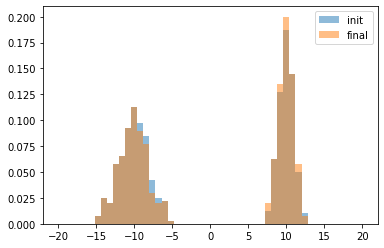

In [278]:
xlims = [-20, 20]
# _ = plt.hist(samples_on_df.x0, label="true", alpha=0.1, color="g", bins=50, range=xlims, density=True)
_ = plt.hist(mh.x[0, :, 0].numpy(), label="init", alpha=.5, bins=50, range=xlims, density=True)
_ = plt.hist(mh.x[-1, :, 0].numpy(), label="final", alpha=.5, bins=50, range=xlims, density=True)
_ = plt.legend()

In [279]:
xx0 = mh.x[0, :, 0].numpy()
xx1 = mh.x[-1, :, 0].numpy()
xx0 = xx0[xx0 < 0.]
xx1 = xx1[xx1 < 0.]

# tf.math.reduce_mean(xx1), tf.math.reduce_variance(xx1)
print("left proportion before \t:", xx0.shape[0] / mh.x[0, :, 0].shape[0])
print("left proportion after \t:", xx1.shape[0] / mh.x[-1, :, 0].shape[0])

left proportion before 	: 0.524
left proportion after 	: 0.498


In [280]:
print("left component mean, var before:")
tf.math.reduce_mean(xx0), tf.math.reduce_variance(xx0)

left component mean, var before:


(<tf.Tensor: shape=(), dtype=float32, numpy=-10.020437>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.693531>)

In [216]:
print("left component mean, var after:")
tf.math.reduce_mean(xx1), tf.math.reduce_variance(xx1)

left component mean, var after:


(<tf.Tensor: shape=(), dtype=float32, numpy=-9.828047>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.6880612>)

In [218]:
plt.scatter(samples_on_df.x0, samples_on_df.x1, label="true", alpha=0.1, color="g")
plt.scatter(mh.x[0, :, 0], mh.x[0, :, 1], label="init", alpha=0.2)
plt.scatter(mh.x[-1, :, 0], mh.x[-1, :, 1], label="final", alpha=0.2)

# x_0 = mh.x[0, :, :].numpy()
# xx = x_0[:, 0]
# yy = x_0[:, 1]
# plt.quiver(xx, yy, best_dir_vec[0] * best_std, best_dir_vec[1] * best_std)
# plt.xlim(-60, 60)
# plt.ylim(-10, 60)

# mode1 = mode_list[0]
# mode2 = mode_list[2]
# plt.scatter(mode1[0], mode1[1], label="mode1", alpha=0.5, color="red")
# plt.scatter(mode2[0], mode2[1], label="mode2", alpha=0.5, color="red")

plt.legend()

In [72]:
xx = mh.x[-1, :, :].numpy()
xx = xx[xx[:, 0] > 20., :]
tf.math.reduce_mean(xx, axis=0), tf.math.reduce_variance(xx, axis=0)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>)

In [102]:
# run dynamic for T steps with test data and optimal params
mh2 = MCMCKernel(log_prob=log_prob_fn)

sample_init_test2 = mh.x[-1, :, :]

mh2.run(
    steps=T, x_init=sample_init_test2, std=best_std, 
    mode1=mode1, mode2=mode2,
    hess1_sqrt=hess1_sqrt, hess2_sqrt=hess2_sqrt,
    hess1_inv_sqrt=hess1_inv_sqrt, hess2_inv_sqrt=hess2_inv_sqrt)

# get perturbed samples
x_t2 = mh2.x[-1, :, :].numpy()

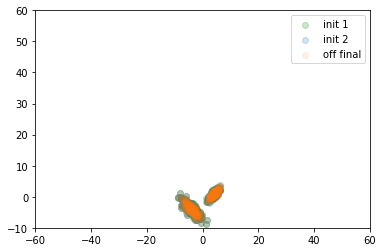

In [103]:
plt.scatter(mh.x[0, :, 0], mh.x[0, :, 1], label="init 1", alpha=0.2, color="g")
plt.scatter(mh2.x[0, :, 0], mh2.x[0, :, 1], label="init 2", alpha=0.2)
plt.scatter(mh2.x[-1, :, 0], mh2.x[-1, :, 1], label="off final", alpha=0.1)

plt.xlim(-60, 60)
plt.ylim(-10, 60)

plt.legend()

In [219]:
# bootstrap test
alpha = 0.05
nrep = 100
num_boot = 800

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n-ntrain)
multinom_samples = bootstrap.multinom.sample((1, num_boot)) # nrep x num_boot x ntest

In [220]:
# get multinomial sample
multinom_one_sample = multinom_samples[0, :] # nrep x num_boost x ntest

# compute p-value
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)

# compute p-value for initial particles
x_0 = mh.x[0, :, :].numpy()
_, p_val_init = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

print(f"p_val before: {p_val_init}, after: {p_val}")

p_val before: 0.9388264669163545, after: 0.5555555555555556


In [221]:
def run_banana_experiment(std_list, log_prob_fn, sample_init_test,
     T, multinom_one_sample, bootstrap, alpha, num_boot, **kwargs):
    
    # run dynamic for T steps with test data and optimal params
    mh = MCMCKernel(log_prob=log_prob_fn)
    
    p_val_res = []
    ksd_res = []
    ksd_scaled_res = []
    for std in tqdm(std_list):
        mh.run(
            steps=T, x_init=sample_init_test, std=std, **kwargs)

        # get perturbed samples
        x_t = mh.x[-1, :, :].numpy()
        
        # compute ksd
        ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
        
        # compute scaled ksd
        _, ksd_val_scaled = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
        ksd_val_scaled = ksd_val_scaled.numpy()

        # compute p-value
        _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)

        p_val_res.append(p_val)
        ksd_res.append(ksd_val)
        ksd_scaled_res.append(ksd_val_scaled)
        
    return p_val_res, ksd_res, ksd_scaled_res

In [222]:
std_list = np.linspace(0.5, 1.5, 26).tolist()

# cov1 = tf.constant([[1., -0.8], [-0.8, 1]])
# cov2 = tf.constant([[1., 0.8], [0.8, 1]])
# hess1_sqrt, hess2_sqrt = tf.linalg.sqrtm(cov1), tf.linalg.sqrtm(cov2)
# hess1_inv_sqrt, hess2_inv_sqrt = tf.linalg.inv(hess1_sqrt), tf.linalg.inv(hess2_sqrt)

p_val_res, ksd_res, ksd_scaled_res = run_banana_experiment(
    std_list=std_list, 
    log_prob_fn=log_prob_fn,
    sample_init_test=sample_init_test,
    T=T,
    multinom_one_sample=multinom_one_sample,
    bootstrap=bootstrap,
    alpha=alpha,
    num_boot=num_boot,
    **proposal_dict
)

  0%|          | 0/26 [00:00<?, ?it/s]

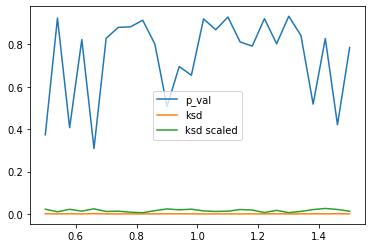

In [223]:
plt.plot(std_list, p_val_res, label="p_val")
plt.plot(std_list, ksd_res, label="ksd")
plt.plot(std_list, ksd_scaled_res, label="ksd scaled")
_ = plt.legend()

In [389]:
dist = models.create_mixture_20_gaussian(loc, ratio=[1., 0.], scale=delta)
sample_init_test = dist.sample(n-ntrain)

In [396]:
def draw_plots(std_list, T):
    _ = plt.figure(figsize=[20, 20])
    for i, std in enumerate(std_list):
        mh.run(
            steps=T, x_init=sample_init_test, std=std, 
            mode1=mode1, mode2=mode2,
            hess1_sqrt=hess1_sqrt, hess2_sqrt=hess2_sqrt,
            hess1_inv_sqrt=hess1_inv_sqrt, hess2_inv_sqrt=hess2_inv_sqrt)
        
        x_t = mh.x[-1, :, :].numpy()
        
        _ = plt.subplot(7, int(np.ceil(len(std_list)/7)), i+1)
        plt.scatter(mh.x[0, :, 0], mh.x[0, :, 1], label="init", alpha=0.2)
        plt.scatter(mh.x[1, :, 0], mh.x[1, :, 1], label="final 1", alpha=1.)
        plt.scatter(mh.x[-1, :, 0], mh.x[-1, :, 1], label="final 2", alpha=1.)
        _ = plt.title(f"std = {std}")
        _ = plt.legend()
        plt.xlim(-100, 100)
        plt.ylim(-70, 70)
        plt.tight_layout()

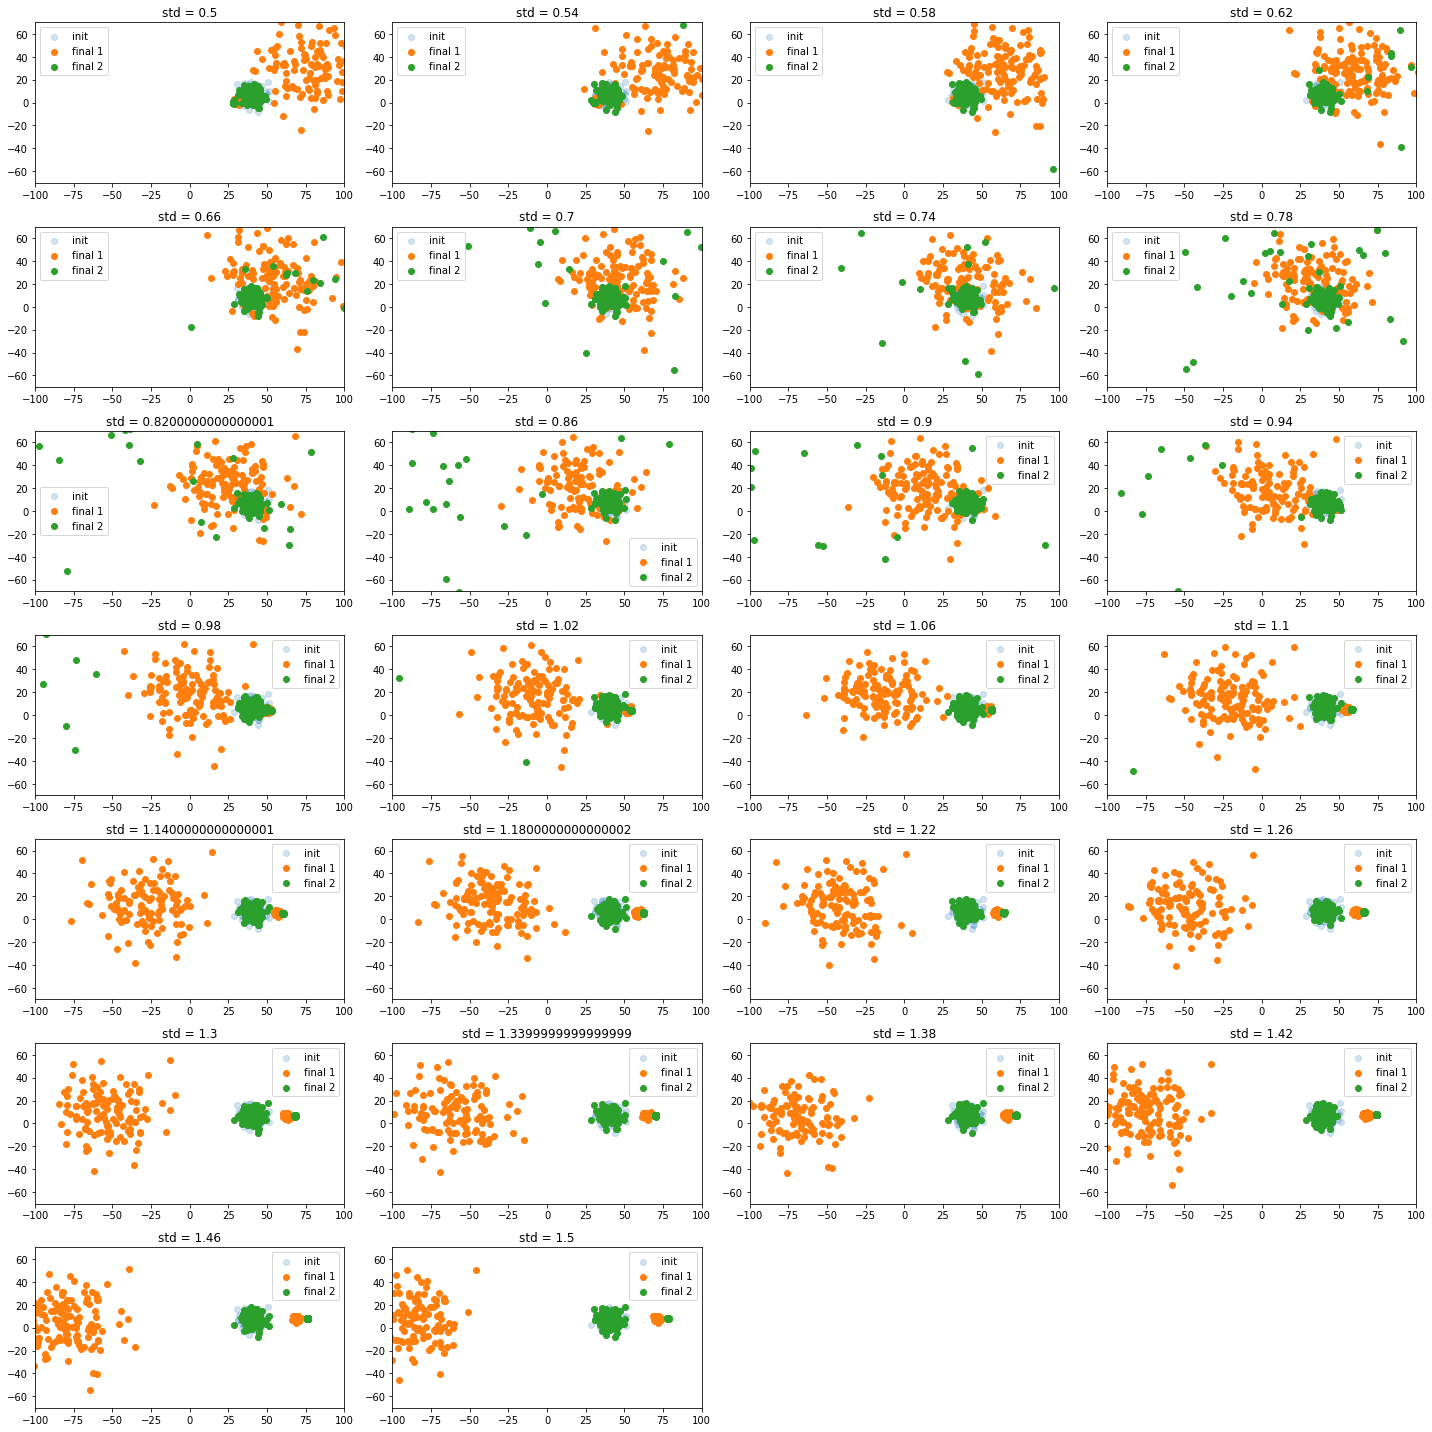

In [397]:
draw_plots(std_list, 3)

1.horizontal: p_val before: 0.7166042446941323, after: 0.33208489388264667


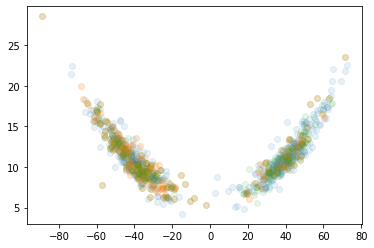

In [286]:
print(f"1.horizontal: p_val before: {p_val_init}, after: {p_val}")

2.diagonal  : p_val before: 0.7290886392009988, after: 0.05118601747815231


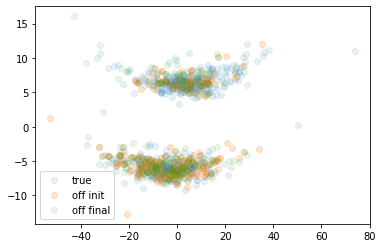

In [59]:
print(f"2.diagonal  : p_val before: {p_val_init}, after: {p_val}")

3.vertical  : p_val before: 0.6853932584269663, after: 0.008739076154806492


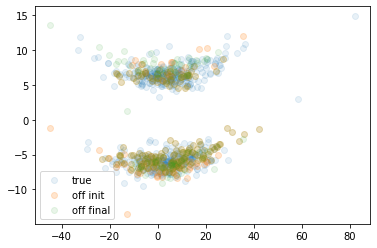

In [77]:
print(f"3.vertical  : p_val before: {p_val_init}, after: {p_val}")

In [208]:
tf.random.set_seed(0)

In [209]:
e1 = tf.eye(dim)[:, 0]
mean1 = [4., 1.]
mean2 = [-4., -4.]

cov1 = tf.constant([[1., 0.8], [0.8, 1]])
cov2 = tf.constant([[1., -0.8], [-0.8, 1]])

scale1 = tf.linalg.cholesky(cov1)
scale2 = tf.linalg.cholesky(cov2)

dist1 = tfd.MultivariateNormalTriL(mean1, scale_tril=scale1)
dist2 = tfd.MultivariateNormalTriL(mean2, scale_tril=scale2)

In [210]:
n = 1000
xx1 = dist1.sample(n).numpy()
xx2 = dist2.sample(n).numpy()

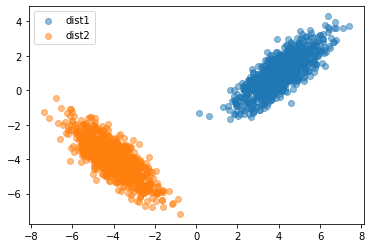

In [211]:
plt.scatter(xx1[:, 0], xx1[:, 1], label="dist1", alpha=0.5)
plt.scatter(xx2[:, 0], xx2[:, 1], label="dist2", alpha=0.5)
_ = plt.legend()

In [212]:
# hessians
mode_list2, hessian_list2 = find_modes(xx2, dist2.log_prob, threshold=threshold)
mode_list1, hessian_list1 = find_modes(xx1, dist1.log_prob, threshold=threshold)

In [213]:
hessian1 = hessian_list1[0]
hessian2 = hessian_list2[0]
hessian1, hessian2

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.99999994, 0.79999995],
        [0.79999995, 1.0000001 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 1.        , -0.80000013],
        [-0.80000013,  1.        ]], dtype=float32)>)

In [214]:
hessian1_sqrt = tf.linalg.sqrtm(hessian1)
hessian2_sqrt = tf.linalg.sqrtm(hessian2)

mode1 = mode_list1[0]
mode2 = mode_list2[0]

In [215]:
dir_vec = mode2 - mode1
sigma = 0.9

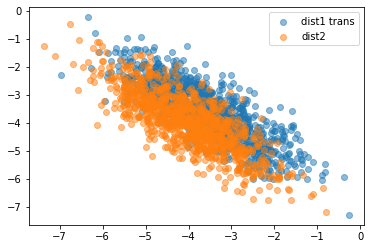

In [220]:
xx1_trans = (xx1 - mode1) @ tf.linalg.inv(hessian1_sqrt) @ hessian2_sqrt + sigma * mode2

plt.scatter(xx1_trans[:, 0], xx1_trans[:, 1], label="dist1 trans", alpha=0.5)
plt.scatter(xx2[:, 0], xx2[:, 1], label="dist2", alpha=0.5)
_ = plt.legend()

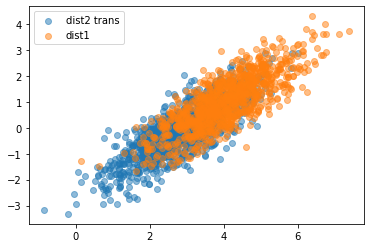

In [222]:
xx2_trans = (xx2 - sigma * mode2) @ tf.linalg.inv(hessian2_sqrt) @ hessian1_sqrt + mode1

plt.scatter(xx2_trans[:, 0], xx2_trans[:, 1], label="dist2 trans", alpha=0.5)
plt.scatter(xx1[:, 0], xx1[:, 1], label="dist1", alpha=0.5)
_ = plt.legend()

# Mixture of 20 Gaussian

In [5]:
tf.random.set_seed(1)

In [6]:
dim = 5
nmodes = 5
means = tfp.distributions.Uniform(low=-tf.ones((dim,))*5, high=tf.ones((dim,))*5).sample(nmodes) # uniform in [-5, 5]^d
# means = tf.constant([[ 3.150137, 3.5368528, 3.494505, -2.2771752, -1.3727772 ],
#  [ 0.33028698, 1.8623676, 0.2722001, 4.1124535, -0.9760752 ],
#  [-4.0837107, -2.8521585, 2.1179333, -1.2412894, 4.7342815 ],
#  [ 2.1172857, 1.1514673, -3.1432784, -4.28977, -1.4204955 ]])

# indicator = tf.cast(tfp.distributions.Bernoulli(probs=0.5).sample(nmodes-1), dtype=bool)
# indicator = tf.concat([tf.constant([True]), indicator], axis=0)
random_weights = tfp.distributions.Uniform(low=0., high=1.).sample(nmodes)
# random_weights = tf.where(indicator, random_weights, 0.)
ratio_sample = random_weights / tf.reduce_sum(random_weights)
# ratio_sample = tf.constant([0.95802206, 0., 0., 0.04197793])

ratio_target = 0.5

target, log_prob_fn = models.create_mixture_20_gaussian(means, ratio=ratio_target, scale=0.1, return_logprob=True)
proposal_off, log_prob_fn_off = models.create_mixture_20_gaussian(means, ratio=ratio_sample, scale=0.1, return_logprob=True)

2022-02-10 18:30:14.757809: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 18:30:15.347545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [20]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

<AxesSubplot:xlabel='x0', ylabel='x1'>

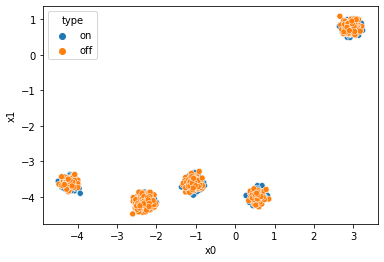

In [21]:
# sns.displot(data=samples_df, x="x0", y="x1", kind="kde", hue="type")
sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")

In [22]:
# find modes
nstart_pts = 200 * dim
mode_threshold = 0.01

unif_dist = tfp.distributions.Uniform(low=-tf.ones((dim,)), high=tf.ones((dim,)))
start_pts = 5. * unif_dist.sample(nstart_pts)

In [23]:
start_pts = samples_off
mode_list, _ = find_modes(start_pts, log_prob_fn, threshold=mode_threshold, max_iterations=50, parallel_iterations=1,)
print("num of modes found:", len(mode_list))

num of modes found: 5


In [24]:
# tf.experimental.numpy.allclose(start_pts, tf.concat([tf.reshape(x, (1, -1)) for x in mode_list], axis=0))

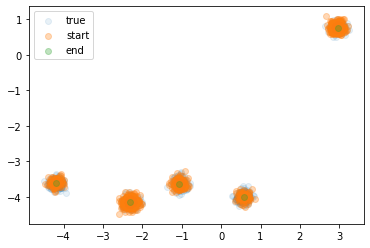

In [25]:
end_pts = tf.concat([tf.reshape(x, (1, -1)) for x in mode_list], axis=0).numpy()
plt.scatter(samples_on_df.x0, samples_on_df.x1, label="true", alpha=0.1)
plt.scatter(start_pts[:, 0], start_pts[:, 1], label="start", alpha=0.3)
plt.scatter(end_pts[:, 0], end_pts[:, 1], label="end", alpha=.3)
plt.legend()

In [26]:
dir_vec_list, dir_ind_list = pairwise_directions(mode_list, return_index=True)

In [27]:
sample_init = samples_off
ntrain = n // 2
std_ls = np.linspace(0.5, 1.5, 26).tolist()
T = 50

sample_init_train, sample_init_test = sample_init[:ntrain, ], sample_init[ntrain:, ]

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)

In [28]:
# find v_{i^*, j^*}, \sigma^*_{i^*, j^*}
best_ksd = 0.
best_ind = 0
if len(mode_list) == 1:
    dir_vec_list = [mode_list[0]]
else:
    dir_vec_list = pairwise_directions(mode_list)

for j, dir_vec in tqdm(enumerate(dir_vec_list)):
    # loop through directional vecs

    for i, std in enumerate(std_ls):
        # loop through jump scales
        
        # run dynamic for T steps
        mh = RandomWalkMH(log_prob=log_prob_fn)
        mh.run(steps=T, std=std, x_init=sample_init_train, dir_vec=dir_vec)

        # compute ksd
        x_t = mh.x[-1, :, :].numpy()
        ksd_val = ksd(x_t, tf.identity(x_t)).numpy()

        # update if ksd is larger
        if ksd_val > best_ksd:
            best_std = std
            best_dir_vec = dir_vec
            best_ksd = ksd_val
            best_ind = j

10it [01:37,  9.78s/it]


In [29]:
print(best_std, best_dir_vec)

# run dynamic for T steps with test data and optimal params
mh = RandomWalkMH(log_prob=log_prob_fn)
mh.run(steps=T, x_init=sample_init_test, std=best_std, dir_vec=best_dir_vec)

# get perturbed samples
x_t = mh.x[-1, :, :].numpy()

0.98 tf.Tensor([ 1.8926933 -0.5351927 -1.9889078  1.6896105 -2.2205958], shape=(5,), dtype=float32)


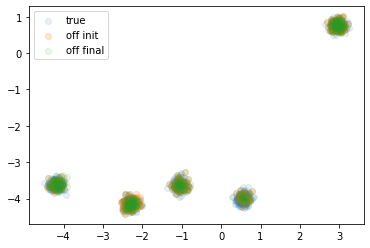

In [30]:
# samples_off_pert = pd.DataFrame({"x0": x_t[:, 0], "x1": x_t[:, 1], "type": "off pert"})
# samples_off_pert = pd.concat([samples_off_pert, samples_off_df], ignore_index=True)

plt.scatter(samples_on_df.x0, samples_on_df.x1, label="true", alpha=0.1)
plt.scatter(mh.x[0, :, 0], mh.x[0, :, 1], label="off init", alpha=0.2)
plt.scatter(mh.x[-1, :, 0], mh.x[-1, :, 1], label="off final", alpha=0.1)
plt.legend()

In [31]:
# bootstrap test
alpha = 0.05
nrep = 100
num_boot = 500
bootstrap = Bootstrap(ksd, n-ntrain)
multinom_samples = bootstrap.multinom.sample((1, num_boot)) # nrep x num_boot x ntest

In [19]:
# get multinomial sample
multinom_one_sample = multinom_samples[0, :] # nrep x num_boost x ntest

# compute p-value
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print(p_val)

0.0499001996007984


In [32]:
# get multinomial sample
multinom_one_sample = multinom_samples[0, :] # nrep x num_boost x ntest

# compute p-value
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print(p_val)

0.19760479041916168
